current_pmv will be predicted given the predicted temperature and humidity (lag 30 min)

if current_pmv does not lie in a threshhold ranging from -0.3-+0.3

water temperature will increase by 0.5 or decreased by 0.5 at the first lag.

The prediction will run iteratively and at each prediction the water_temp column will be edited if necessary.

To simulate df as real time data there will be a counter that will increment with each iteration and serve as a reference to split df between future values (not seen by the model) and present and historical values. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from math import sqrt
import logging

from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction.feature_calculators import sum_values, quantile

from pmv import pmv_ppd_diy
from feature_selection import check_stationarity, scaling, feat_extraction

2024-03-20 14:04:07.329630: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 14:04:07.330818: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 14:04:07.348396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 14:04:07.348415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 14:04:07.348900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
df_trained = pd.read_csv("/home/fraia/Arduino/Predictive Model/data_cl/home_data_cl_21_03.csv")
df = pd.read_csv("/home/fraia/Arduino/Predictive Model/data/Unseen.csv")

In [3]:
df_trained_cl = df_trained[::6]
df_trained_cl = df_trained_cl.drop(columns = ["Unnamed: 0", "id"])
df_trained_cl = df_trained_cl.set_index("timestamp")
df_trained_cl.isna().sum()

sense_hum     0
sense_temp    0
open_hum      0
open_temp     0
pressure      0
water_temp    0
dtype: int64

In [4]:
df_cl = df[::6]
df_cl.reset_index(drop=True, inplace=True)

In [5]:
columns_drop = ["id"]
df_cl = df_cl.drop(columns=columns_drop)

df_cl["timestamp"] = pd.to_datetime(df_cl["timestamp"])
df_cl = df_cl.set_index("timestamp")
df_cl = df_cl[1:]

In [6]:
display(df_trained_cl)
display(df_cl)

sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-02-21 09:24:31       40.8        21.9      70.0       6.74    1027.0   
2024-02-21 09:50:24       41.6        21.6      68.0       7.30    1028.0   
2024-02-21 10:21:54       41.5        21.7      65.0       8.89    1028.0   
2024-02-21 10:52:40       41.4        21.7      64.0       9.80    1028.0   
2024-02-21 11:18:14       41.4        21.8      62.0      10.47    1027.0   
...                        ...         ...       ...        ...       ...   
2024-03-05 05:15:55       38.5        21.9      70.0       5.98    1021.0   
2024-03-05 05:46:33       38.2        22.0      70.0       6.01    1021.0   
2024-03-05 06:17:12       38.1        22.0      70.0       6.10    1021.0   
2024-03-05 06:47:51       38.0        22.1      71.0       5.49    1021.0   
2024-03-05 07:18:29       38.0        22.1      67.0       5.56    1022.0   

                     water_temp  
timestamp                        
2024-02-21 09:24:31        30.0  
2024-02-21 09:50:24        28.0  
2024-02-21 10:21:54        27.0  
2024-02-21 10:52:40        26.0  
2024-02-21 11:18:14        25.0  
...                         ...  
2024-03-05 05:15:55        30.0  
2024-03-05 05:46:33        30.0  
2024-03-05 06:17:12        30.0  
2024-03-05 06:47:51        30.0  
2024-03-05 07:18:29        30.0  

[649 rows x 6 columns]

sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 07:44:01       38.0        22.1        67       5.51      1022   
2024-03-05 08:35:08       37.7        22.2        67       5.73      1022   
2024-03-05 09:05:47       37.6        22.1        67       6.35      1023   
2024-03-05 09:36:27       37.4        22.2        67       6.92      1010   
2024-03-05 10:07:07       37.3        22.1        62       8.07      1023   
...                        ...         ...       ...        ...       ...   
2024-03-07 16:50:28       37.4        21.8        82       9.00      1006   
2024-03-07 17:21:12       37.6        21.7        86       8.81      1005   
2024-03-07 17:57:26       37.8        21.6        84       8.85      1004   
2024-03-07 18:28:12       37.9        21.5        85       8.20      1005   
2024-03-07 18:58:53       38.1        21.5        89       6.29      1005   

                     water_temp  
timestamp                        
2024-03-05 07:44:01         NaN  
2024-03-05 08:35:08         NaN  
2024-03-05 09:05:47         NaN  
2024-03-05 09:36:27         NaN  
2024-03-05 10:07:07         NaN  
...                         ...  
2024-03-07 16:50:28         NaN  
2024-03-07 17:21:12         NaN  
2024-03-07 17:57:26         NaN  
2024-03-07 18:28:12         NaN  
2024-03-07 18:58:53         NaN  

[106 rows x 6 columns]

In [7]:
df_cl

sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 07:44:01       38.0        22.1        67       5.51      1022   
2024-03-05 08:35:08       37.7        22.2        67       5.73      1022   
2024-03-05 09:05:47       37.6        22.1        67       6.35      1023   
2024-03-05 09:36:27       37.4        22.2        67       6.92      1010   
2024-03-05 10:07:07       37.3        22.1        62       8.07      1023   
...                        ...         ...       ...        ...       ...   
2024-03-07 16:50:28       37.4        21.8        82       9.00      1006   
2024-03-07 17:21:12       37.6        21.7        86       8.81      1005   
2024-03-07 17:57:26       37.8        21.6        84       8.85      1004   
2024-03-07 18:28:12       37.9        21.5        85       8.20      1005   
2024-03-07 18:58:53       38.1        21.5        89       6.29      1005   

                     water_temp  
timestamp                        
2024-03-05 07:44:01         NaN  
2024-03-05 08:35:08         NaN  
2024-03-05 09:05:47         NaN  
2024-03-05 09:36:27         NaN  
2024-03-05 10:07:07         NaN  
...                         ...  
2024-03-07 16:50:28         NaN  
2024-03-07 17:21:12         NaN  
2024-03-07 17:57:26         NaN  
2024-03-07 18:28:12         NaN  
2024-03-07 18:58:53         NaN  

[106 rows x 6 columns]

In [47]:
predictions = []
hvac_final = []
pmv_final = []


#df_rolled = df_rolled.drop(columns = "pressure")

In [48]:
class Thermostat:
     def __init__(self, df_train, df_unseen, heating_rate, cooling_rate, threshold, model_path = "/home/fraia/Arduino/Predictive Model/LSTM/models_temp/model11_21_01.h5"):
         self.counter = 0
         #self.upper_bound = self.updated[-1]-len(hvac_final)
         #self.lower_bound = 6
         self.n_past = 5
         self.n_future = 1
         self.model = load_model(model_path)
         
         self.adjustment = 0
         self.df1 = df_train
         self.df2 = df_unseen
         self.updated = self.concat()
         self.rolled = self.rolling(self.updated)
         self.relevant_vars = ["sense_temp", "st_wt", "open_temp__sum_values", 'sense_hum__quantile__q_0.8']

         self.heating_rate = heating_rate
         self.cooling_rate = cooling_rate
         self.threshold = threshold
     
     def concat(self):
          print("Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          print("counter:", self.counter)
          print("predictions", predictions)
          print("hvac", hvac_final)
          df = self.df1
          unseen_rows = self.df2.head(self.counter)
          df_updated = pd.concat([df, unseen_rows], axis = 0)

          if len(hvac_final) > 0:
               df_updated["water_temp"][-len(hvac_final):] = hvac_final
               #df_updated["water_temp"][df.index[-1]:len(hvac_final)] = hvac_final
          if len(predictions) > 0:
               df_updated["sense_temp"][-len(predictions):] = predictions
          print("updated:", df_updated.tail())
          return df_updated

     def rolling(self, df):
          print("Rolling...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          df_rolled = df.rolling(window=20).mean().dropna()
          df_rolled = df_rolled[['sense_temp','water_temp','sense_hum', 'open_temp', 'open_hum']]
          print("rolled:\n", df_rolled)
          
          if np.isnan(df_rolled["water_temp"].iloc[-1]):
               if len(hvac_final) > 0:
                    df_rolled["water_temp"][-1] = hvac_final[-1]
               else:
                    df_rolled["water_temp"][-1] = df_rolled["water_temp"][-2]
                    
          if len(predictions) > 0:
               df_rolled["sense_temp"][-1] = predictions[-1]

          df_rolled["st_wt"] = df_rolled["sense_temp"]*df_rolled["water_temp"]
          print("df_rolled:\n",df_rolled.tail())
          return df_rolled
     
     def preprocessing(self, df):
          print("Preprocessing...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          df_diff = df.diff().dropna()
          print("df_diff:",df_diff)
          df_stationar = check_stationarity(df_diff)
          print("df_stationar:\n",df_stationar)
          df_scaled, scaler = scaling(df_stationar)
          print("scaled:\n",df_scaled)
          #X, y = feat_extraction(df_scaled, "sense_temp")
          #df_scaled = df_scaled.set_index("timestamp")
          df_fe = df_scaled
          df_fe["open_temp__sum_values"] = sum_values(x = df_fe["open_temp"])
          df_fe["sense_hum__quantile__q_0.8"] = quantile(x = df_fe["sense_hum"], q = 0.8)
          df_ready = pd.concat([df_scaled["sense_temp"], df_scaled["st_wt"], df_fe["open_temp__sum_values"], df_fe["sense_hum__quantile__q_0.8"]], axis = 1)
          print("ready:\n",df_ready)
          return df_ready, scaler
          
     def pred_df(self, df):
          print("Slicing required time window...---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          pred_df = pd.DataFrame(df[-6:], columns=df.columns)
          print("pred_df:\n",pred_df)
          return pred_df

     def x_array(self, df):
          print("Shaping 3D array...------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          X = []

          for i in range(self.n_past, len(df) - self.n_future + 1):
              X.append(df.iloc[i - self.n_past:i, :])
          X = np.array(X)

          print("shape: {}\n".format(X.shape)) 
          return X
     
     def predictions(self, array):
          print("Predicting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          prediction = self.model.predict(array)
          return prediction
     
     def wrapping_or_adjusting(self, pred, scaler):
          global predictions, hvac_final
          # Unscaling 
          # Transformation to real values (without scaling and difference)
          forecast_copies = np.repeat(pred, self.rolled.shape[1], axis = -1)
          y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

          # Differencing
          #last real value of train set
          if len(predictions) == 0:
              diff_value = self.rolled["sense_temp"][-1]
          else:
              diff_value = predictions[-1]
          
          y_pred_real = y_pred_future.cumsum() + diff_value
          hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future

          print("The predicted temperature for {0} is {1}°C".format(self.rolled.index[-1], y_pred_real[0]))
              
          if self.adjustment == 1:
               print("Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
               # Compute predicted pmv for adjustment made 
               pmv_ppd = pmv_ppd_diy(predicted_temp=y_pred_real, predicted_hum=hum_pred)

               # Update lists
               predictions.append(y_pred_real[0])
               pmv_final.append(pmv_ppd["pmv"][0])
               
               # Update trackers
               self.adjustment -= 1
               self.counter += 1
               #self.upper_bound += 1
               #self.lower_bound += 1

          else:
               self.adjustment += 1
               def heat():
                    print("Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
                    pmv_ppd = pmv_ppd_diy(predicted_temp=y_pred_real, predicted_hum=hum_pred)
                    pmv_difference = pmv_ppd["pmv"][0] - 0
                    pmv_difference = pmv_difference**2
                    pmv_difference = sqrt(pmv_difference)

                    current_wt = self.rolled["water_temp"].iloc[-1]
                    
                    if current_wt <= self.threshold:
                         if pmv_ppd["pmv"][0] < -2:
                              print("Critical thermal comfort violation...")
                              current_wt += self.heating_rate * pmv_difference
                         elif pmv_ppd["pmv"][0] > 2:
                              print("Critical thermal comfort violation...")
                              current_wt -= self.cooling_rate * pmv_difference
                         elif (-2 < pmv_ppd["pmv"][0] < -1):
                              print("High thermal comfort violation...")
                              current_wt += self.heating_rate * pmv_difference
                         elif (1 < pmv_ppd["pmv"][0]< 2):
                              print("High thermal comfort violation...")
                              current_wt -= self.cooling_rate * pmv_difference
                         elif (-1 <= pmv_ppd["pmv"][0] < -0.1):
                              print("Low thermal comfort violation...")
                              current_wt += self.heating_rate * pmv_difference
                         elif (0.1 < pmv_ppd["pmv"][0] <= 1):
                              print("Low thermal comfort violation...")
                              current_wt -= self.cooling_rate * pmv_difference
                         else:
                             print("Within thermal comfort") 
                    hvac_final.append(current_wt)
               heat()
               
          print("==================================================================================================================================================================================================================================================")      
          return y_pred_real  

     def run_simulation(self):
          while self.counter < len(self.df2):
              updated_df = self.concat()
              rolled_df = self.rolling(df = updated_df)
              df_ready, scaler = self.preprocessing(rolled_df)
              df_pred = self.pred_df(df_ready)
              X = self.x_array(df_pred)
              prediction = self.predictions(X)
              self.wrapping_or_adjusting(prediction, scaler)

          
 

In [49]:
thermostat = Thermostat(df_train=df_trained_cl, df_unseen=df_cl, heating_rate=10, cooling_rate=10, threshold=40)

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 0
predictions []
hvac []
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 05:15:55       38.5        21.9      70.0       5.98    1021.0   
2024-03-05 05:46:33       38.2        22.0      70.0       6.01    1021.0   
2024-03-05 06:17:12       38.1        22.0      70.0       6.10    1021.0   
2024-03-05 06:47:51       38.0        22.1      71.0       5.49    1021.0   
2024-03-05 07:18:29       38.0        22.1      67.0       5.56    1022.0   

                     water_temp  
timestamp                        
2024-03-05 05:15:55        30.0  
2024-03-05 05:46:33        30.0  
2024-03-05 06:17:12   

In [50]:
logging.basicConfig(level=logging.INFO)  # Set logging level
thermostat.run_simulation()

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 0
predictions []
hvac []
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 05:15:55       38.5        21.9      70.0       5.98    1021.0   
2024-03-05 05:46:33       38.2        22.0      70.0       6.01    1021.0   
2024-03-05 06:17:12       38.1        22.0      70.0       6.10    1021.0   
2024-03-05 06:47:51       38.0        22.1      71.0       5.49    1021.0   
2024-03-05 07:18:29       38.0        22.1      67.0       5.56    1022.0   

                     water_temp  
timestamp                        
2024-03-05 05:15:55        30.0  
2024-03-05 05:46:33        30.0  
2024-03-05 06:17:12   

1/1 [==============================] - 0s 108ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.453393936157227°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 0
predictions []
hvac [31.825]
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 05:15:55       38.5        21.9      70.0       5.98    1021.0   
2024-03-05 05:46:33       38.2        22.0      70.

/tmp/ipykernel_65253/3732815235.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff_value = self.rolled["sense_temp"][-1]
/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work t

1/1 [==============================] - 0s 12ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.507944107055664°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 1
predictions [21.45336]
hvac [31.825, 31.724999999999998]
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 05:46:33       38.2    22.00000      70.0       6.01    1021.0   
2024-03-05 06:17:12     

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.576090
p-value: 0.000143


water_temp
ADF Statistic: -5.274622
p-value: 0.000006


sense_hum
ADF Statistic: -4.201881
p-value: 0.000654


open_temp
ADF Statistic: -3.661960
p-value: 0.004681


open_hum
ADF Statistic: -3.864477
p-value: 0.002312


st_wt
ADF Statistic: -5.350905
p-value: 0.000004


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 06:17:12    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 07:18:29       38.0   22.100000      67.0       5.56    1022.0   
2024-03-05 07:44:01       38.0   21.453360      67.0       5.51    1022.0   
2024-03-05 08:35:08       37.7   21.508760      67.0       5.73    1022.0   
2024-03-05 09:05:47       37.6   21.555170      67.0       6.35    1023.0   
2024-03-05 09:36:27       37.4   21.599121      67.0       6.92    1010.0   

                     water_temp  
timestamp                        
2024-03-05 07:18:29      30.000  
2024-03-05 07:44:01      31.825  
2024-03-05 08:35:08      31.725  
2024-03-05 09:05:47      31.625  
2024-03-05 09:36:27      31.625  
Rolling...-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 21.681968688964844°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 5
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425]
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 07:44:01       38.0   21.453360      67.0       5.51    1022.0   
20

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.458133
p-value: 0.000234


water_temp
ADF Statistic: -5.233421
p-value: 0.000008


sense_hum
ADF Statistic: -4.249955
p-value: 0.000542


open_temp
ADF Statistic: -3.710831
p-value: 0.003963


open_hum
ADF Statistic: -3.674208
p-value: 0.004491


st_wt
ADF Statistic: -5.225277
p-value: 0.000008


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 09:05:47    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_diff:                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 09:36:27    0.039956     0.07625     -0.195    -0.0870      0.20   
2024-03-05 10:07:07    0.042011     0.07125     -0.195    -0.0205     -0.05   
2024-03-05 10:37:48    0.039088     0.02125     -0.190     0.0410     -0.25   
2024-03-05 11:13:34    0.036197     0.01625     -0.185     0.0815     -0.50   
2024-03-05 11:44:12    0.114878     0.01625

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

ready:
                      sense_temp     st_wt  open_temp__sum_values  \
timestamp                                                          
2024-02-21 19:01:41   -0.354224 -1.544869           2.664535e-14   
2024-02-21 19:32:20   -0.117265 -0.059114           2.664535e-14   
2024-02-21 19:57:52   -0.235745  0.102122           2.664535e-14   
2024-02-21 20:23:24   -0.354224  0.443485           2.664535e-14   
2024-02-21 20:54:02   -0.472704  0.603395           2.664535e-14   
...                         ...       ...                    ...   
2024-03-05 10:07:07    0.996699  0.428816           2.664535e-14   
2024-03-05 10:37:48    0.927443  0.235797           2.664535e-14   
2024-03-05 11:13:34    0.858930  0.203364           2.664535e-14   
2024-03-05 11:44:12    0.786727  0.187987           2.664535e-14   
2024-03-05 12:14:52    2.750976  0.593975           2.664535e-14   

                     sense_hum__quantile__q_0.8  
timestamp                                        
2024-02

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.210643
p-value: 0.000632


water_temp
ADF Statistic: -5.157212
p-value: 0.000011


sense_hum
ADF Statistic: -4.316993
p-value: 0.000415


open_temp
ADF Statistic: -3.730056
p-value: 0.003710


open_hum
ADF Statistic: -3.661675
p-value: 0.004686


st_wt
ADF Statistic: -5.070151
p-value: 0.000016


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 11:13:34    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.019388
p-value: 0.000020


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 11:44:12    0.033150     0.01625     -0.185     0.1125     -0.50   
2024-03-05 12:14:52    0.029865     0.01625     -0.170     0.1555     -0.60   
2024-03-05 12:45:31    0.021422     0.01125     -0.150     0.2035     -0.80   
2024-03-05 13:16:11    0.022840     0.01125     -0.120     0.2260

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_diff:                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 12:14:52    0.029865     0.01125     -0.170     0.1555     -0.60   
2024-03-05 12:45:31    0.021422     0.01125     -0.150     0.2035     -0.80   
2024-03-05 13:16:11    0.022840     0.01125     -0.120     0.2260     -0.90   
2024-03-05 13:46:57    0.019022     0.05625     -0.115     0.2675     -1.20   
2024-03-05 14:17:42    0.127192     0.05625

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 15ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.937522888183594°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 15
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.224999999999998, 31.125, 31.125, 31.125]
updat

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 23ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.95182228088379°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 16
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.224999999999998, 31.125, 31.125, 31.

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 21.9632511138916°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 17
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.224999999999998, 31.125, 31.125, 31.125, 31.125, 31.025]
updated:             

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 12ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.971338272094727°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 18
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.2249999999999

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 25ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.96836280822754°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 18
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 21ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.96640396118164°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 19
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -4.057747
p-value: 0.001137


st_wt
ADF Statistic: -4.750909
p-value: 0.000067


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41         NaN    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20    0.010000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.005000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.005000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.005000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 15:49:40   -0.004285     0.05625     -0.040     0.3270     -1.40   
2024-03-05 16:20:21   -0.004429     0.05125     -0.025     0.3445     -1.40   
2024-03-05 16:51:01    0.000404     0.05125     -0.015     0.3410     -1.50   
2024-03-05 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -4.063054
p-value: 0.001114


st_wt
ADF Statistic: -4.818309
p-value: 0.000050


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41         NaN    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20    0.010000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.005000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.005000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.005000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 16:20:21   -0.004429     0.05125     -0.025     0.3445     -1.40   
2024-03-05 16:51:01    0.000404     0.05125     -0.015     0.3410     -1.50   
2024-03-05 17:21:45   -0.005149     0.05125     -0.010     0.3735     -1.45   
2024-03-05 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -4.066522
p-value: 0.001100


st_wt
ADF Statistic: -4.874806
p-value: 0.000039


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41         NaN    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20    0.010000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.005000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.005000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.005000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 16:51:01    0.000404     0.05125     -0.015     0.3410     -1.50   
2024-03-05 17:21:45   -0.005149     0.05125     -0.010     0.3735     -1.45   
2024-03-05 22:42:21   -0.000098     0.05125      0.100     0.0965     -0.15   
2024-03-05 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -4.068395
p-value: 0.001092


st_wt
ADF Statistic: -5.091172
p-value: 0.000015


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41         NaN    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20    0.010000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.005000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.005000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.005000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 17:21:45   -0.005149     0.05125     -0.010     0.3735     -1.45   
2024-03-05 22:42:21   -0.000098     0.05125      0.100     0.0965     -0.15   
2024-03-05 23:09:44    0.032220    -0.04000      0.010     0.0940     -0.10   
2024-03-05 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.217017
p-value: 0.000008


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 22:42:21   -0.006680     0.05125      0.100     0.0965     -0.15   
2024-03-05 23:09:44    0.025539    -0.04000      0.010     0.0940     -0.10   
2024-03-05 23:40:23    0.022683    -0.03500      0.025     0.0540      0.00   
2024-03-06 00:11:02    0.020544    -0.03000      0.030    -0.0040

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 21.994325637817383°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 25
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 3

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 21.994035720825195°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 26
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 3

/tmp/ipykernel_65253/3732815235.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_rolled["sense_temp"][-1] = predictions[-1]
/tmp/ipykernel_65253/3732815235.py:51: FutureWarning: Series.__setitem__ treating keys as positions is depreca

1/1 [==============================] - 0s 25ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.008167266845703°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 27
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167]
hvac [31.825, 31.724999999999998, 31.625, 31.625

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_hum
ADF Statistic: -4.410966
p-value: 0.000284


open_temp
ADF Statistic: -3.880928
p-value: 0.002180


open_hum
ADF Statistic: -4.027320
p-value: 0.001274


st_wt
ADF Statistic: -5.278362
p-value: 0.000006


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 00:11:02    0.020544      -0.030      0.030    -0.0040      0.00   
2024-03-06 00:41:41    0.018448      -0.025      0.025    -

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 11ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.032684326171875°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 29
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684]
hvac [31.825, 31.724999999

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.04323959350586°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 30
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 14ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.061233520507812°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 31
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 02:44:18    0.012900      -0.015      0.000    -0.2510      0.80   
2024-03-06 03:14:56    0.011769      -0.020     -0.015    -0.2885      1.00   
2024-03-06 03:45:34    0.010740      -0.015     -0.045    -0.3145      1.10   
2024-03-06 04:16:13    0.009797      -0.015     -0.065    -0.3470      1.25   
2024-03-06 04:46:51    0.088588      

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 26ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.075817108154297°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 33
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.082088470458984°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 34
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.08218002319336°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 35
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075878, 22.08218]
hvac [31.825, 31.

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.093101501464844°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 36
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.097984313964844°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 38
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075878, 22.08218, 22.087914, 22.09

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

water_temp
ADF Statistic: -5.306877
p-value: 0.000005


sense_hum
ADF Statistic: -4.325597
p-value: 0.000401


open_temp
ADF Statistic: -3.931929
p-value: 0.001812


open_hum
ADF Statistic: -4.036614
p-value: 0.001230


st_wt
ADF Statistic: -5.338715
p-value: 0.000005


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 05:48:09    0.007762      -0.010     -0.090    -0.4620      1.70   
202

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.367911
p-value: 0.000338


water_temp
ADF Statistic: -5.318402
p-value: 0.000005


sense_hum
ADF Statistic: -4.247920
p-value: 0.000546


open_temp
ADF Statistic: -3.657646
p-value: 0.004750


open_hum
ADF Statistic: -3.880173
p-value: 0.002186


st_wt
ADF Statistic: -5.352327
p-value: 0.000004


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 06:49:25    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.265072
p-value: 0.000510


water_temp
ADF Statistic: -5.321161
p-value: 0.000005


sense_hum
ADF Statistic: -4.279176
p-value: 0.000483


open_temp
ADF Statistic: -3.649101
p-value: 0.004889


open_hum
ADF Statistic: -3.884860
p-value: 0.002149


st_wt
ADF Statistic: -5.376959
p-value: 0.000004


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 07:20:03    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_diff:                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 08:21:20    0.006705       -0.01     -0.125    -0.4945      1.90   
2024-03-06 08:51:59    0.007011       -0.01     -0.235    -0.1800      0.60   
2024-03-06 09:22:37    0.007327       -0.01     -0.145    -0.1210      0.35   
2024-03-06 09:53:16    0.007620       -0.01     -0.135    -0.0590      0.15   
2024-03-06 10:23:55    0.065750       -0.01

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.128463745117188°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 44
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.133350372314453°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 46
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075878, 22.08218, 22.087914, 22.09

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 22ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.142892837524414°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 47
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 19ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.14727020263672°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 48
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.0326

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.403454
p-value: 0.000003


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 11:25:12    0.007417      -0.010     -0.110     0.1475     -0.30   
2024-03-06 11:55:50    0.006966      -0.010     -0.100     0.1955     -0.50   
2024-03-06 12:26:29    0.006502      -0.010     -0.085     0.2620     -0.75   
2024-03-06 12:57:11    0.006095      -0.010     -0.070     0.3420

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 20ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.155048370361328°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 50
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 20ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.158550262451172°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 51
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.396110
p-value: 0.000302


water_temp
ADF Statistic: -5.370642
p-value: 0.000004


sense_hum
ADF Statistic: -4.395576
p-value: 0.000302


open_temp
ADF Statistic: -3.744693
p-value: 0.003527


open_hum
ADF Statistic: -3.918535
p-value: 0.001903


st_wt
ADF Statistic: -5.416971
p-value: 0.000003


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 12:57:11    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 20ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.164892196655273°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 53
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.448418
p-value: 0.000243


water_temp
ADF Statistic: -5.378711
p-value: 0.000004


sense_hum
ADF Statistic: -4.393847
p-value: 0.000304


open_temp
ADF Statistic: -3.753978
p-value: 0.003415


open_hum
ADF Statistic: -3.930337
p-value: 0.001823


st_wt
ADF Statistic: -5.425674
p-value: 0.000003


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 13:58:26    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.473187
p-value: 0.000220


water_temp
ADF Statistic: -5.379688
p-value: 0.000004


sense_hum
ADF Statistic: -4.397579
p-value: 0.000300


open_temp
ADF Statistic: -3.764912
p-value: 0.003287


open_hum
ADF Statistic: -3.935666
p-value: 0.001787


st_wt
ADF Statistic: -5.432788
p-value: 0.000003


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 14:29:04    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 12ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.172603607177734°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 57
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.174745559692383°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 58
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075878, 22.08218, 22.087914, 22.09

/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_updated["water_temp"][-len(hvac_final):] = hvac_final
/tmp/ipykernel_65253/3732815235.py:34: FutureWarning: ChainedAssignmentError: behaviour will change

open_temp
ADF Statistic: -3.770244
p-value: 0.003227


open_hum
ADF Statistic: -3.917795
p-value: 0.001908


st_wt
ADF Statistic: -5.445507
p-value: 0.000003


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 16:01:01    0.004452      -0.010      0.100     0.5240     -1.45   
2024-03-06 16:31:40    0.004277      -0.010      0.110     0.5295     -1.70   
2024-03-06 17:02:19    0.004118    

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 17ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.178735733032227°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 60
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

ready:
                      sense_temp     st_wt  open_temp__sum_values  \
timestamp                                                          
2024-02-21 19:01:41   -0.382767 -1.604810          -7.105427e-15   
2024-02-21 19:32:20   -0.135918 -0.060937          -7.105427e-15   
2024-02-21 19:57:52   -0.259343  0.106605          -7.105427e-15   
2024-02-21 20:23:24   -0.382767  0.461321          -7.105427e-15   
2024-02-21 20:54:02   -0.506191  0.627486          -7.105427e-15   
...                         ...       ...                    ...   
2024-03-06 17:02:19    0.089157 -0.057054          -7.105427e-15   
2024-03-06 17:33:04    0.085574 -0.038778          -7.105427e-15   
2024-03-06 18:03:44    0.082248 -0.039499          -7.105427e-15   
2024-03-06 18:34:23    0.079242 -0.040151          -7.105427e-15   
2024-03-06 19:05:03    0.796632  0.113898          -7.105427e-15   

                     sense_hum__quantile__q_0.8  
timestamp                                        
2024-02

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.182477951049805°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 61
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

rolled:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum
timestamp                                                                  
2024-02-21 18:31:01   21.830000      23.800     41.855    12.5150     59.30
2024-02-21 19:01:41   21.815000      23.400     41.970    12.8645     59.05
2024-02-21 19:32:20   21.810000      23.400     42.050    13.1650     59.00
2024-02-21 19:57:52   21.800000      23.450     42.140    13.3735     59.15
2024-02-21 20:23:24   21.785000      23.600     42.235    13.5210     59.40
...                         ...         ...        ...        ...       ...
2024-03-06 18:34:23   22.145957      30.795     36.430    10.6035     57.05
2024-03-06 19:05:03   22.149564      30.790     36.545    11.0265     55.80
2024-03-06 19:35:44   22.153062      30.785     36.660    11.3705     54.70
2024-03-06 20:06:25   22.156447      30.780     36.780    11.6750     53.75
2024-03-06 20:37:05   22.159706      30.775     36.900    11.8995     53.05

[6

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

ready:
                      sense_temp     st_wt  open_temp__sum_values  \
timestamp                                                          
2024-02-21 19:01:41   -0.384116 -1.610588          -1.776357e-14   
2024-02-21 19:32:20   -0.136514 -0.060902          -1.776357e-14   
2024-02-21 19:57:52   -0.260315  0.107272          -1.776357e-14   
2024-02-21 20:23:24   -0.384116  0.463323          -1.776357e-14   
2024-02-21 20:54:02   -0.507917  0.630114          -1.776357e-14   
...                         ...       ...                    ...   
2024-03-06 19:05:03    0.076583 -0.040625          -1.776357e-14   
2024-03-06 19:35:44    0.073913 -0.041206          -1.776357e-14   
2024-03-06 20:06:25    0.071084 -0.041819          -1.776357e-14   
2024-03-06 20:37:05    0.067984 -0.042491          -1.776357e-14   
2024-03-06 21:07:45    0.633305  0.078929          -1.776357e-14   

                     sense_hum__quantile__q_0.8  
timestamp                                        
2024-02

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.472629
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 19:35:44    0.003499      -0.005      0.115     0.3440     -1.10   
2024-03-06 20:06:25    0.003384      -0.005      0.120     0.3045     -0.95   
2024-03-06 20:37:05    0.003259      -0.005      0.120     0.2245     -0.70   
2024-03-06 21:07:45    0.003104      -0.005      0.120     0.1645

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_diff:                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-06 20:06:25    0.003384      -0.005      0.120     0.3045     -0.95   
2024-03-06 20:37:05    0.003259      -0.005      0.120     0.2245     -0.70   
2024-03-06 21:07:45    0.003104      -0.005      0.120     0.1645     -0.55   
2024-03-06 21:38:24    0.002932      -0.005      0.120     0.0770     -0.20   
2024-03-06 22:09:02    0.022580      -0.005

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 30ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.19040870666504°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 68
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.061

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

shape: (1, 5, 4)

Predicting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

1/1 [==============================] - 0s 12ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.19125747680664°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 69
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 2

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 11ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.19196319580078°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 70
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.061

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.192522048950195°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 71
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075878, 22.08218, 22.087914, 22.09

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 13ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.193204879760742°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 72
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.193336486816406°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 73
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

scaled:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.387052   -1.566418   1.160835   1.555329 -0.288662   
2024-02-21 19:32:20   -0.137612   -0.037648   0.824114   1.338870 -0.053586   
2024-02-21 19:57:52   -0.262332    0.153448   0.920320   0.932458  0.181490   
2024-02-21 20:23:24   -0.387052    0.535640   0.968423   0.662989  0.299028   
2024-02-21 20:54:02   -0.511772    0.726736   1.016526   0.442113  0.475335   
...                         ...         ...        ...        ...       ...   
2024-03-07 00:11:38    0.037775   -0.056758   0.920320  -0.812462  0.534104   
2024-03-07 00:42:18    0.033771   -0.056758   0.872217  -0.916274  0.710410   
2024-03-07 01:12:57    0.029922   -0.056758   0.391187  -1.009042  0.769179   
2024-03-07 01:43:36    0.026190   -0.037648   0.198775  -1.148194  0.945486   
2024-03-07 02:14:15    0.249647   -0.037648

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.516792
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 00:42:18    0.001871      -0.005      0.085    -0.2100      0.60   
2024-03-07 01:12:57    0.001716      -0.005      0.035    -0.2310      0.65   
2024-03-07 01:43:36    0.001567       0.000      0.015    -0.2625      0.80   
2024-03-07 02:14:15    0.001421       0.000      0.015    -0.2910

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.520877
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 01:12:57    0.001716      -0.005      0.035    -0.2310      0.65   
2024-03-07 01:43:36    0.001567       0.000      0.015    -0.2625      0.80   
2024-03-07 02:14:15    0.001421       0.000      0.015    -0.2910      0.80   
2024-03-07 02:44:53    0.001283       0.000      0.010    -0.2880

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

ready:
                      sense_temp     st_wt  open_temp__sum_values  \
timestamp                                                          
2024-02-21 19:01:41   -0.387829 -1.623254          -7.105427e-15   
2024-02-21 19:32:20   -0.137850 -0.060471          -7.105427e-15   
2024-02-21 19:57:52   -0.262840  0.109124          -7.105427e-15   
2024-02-21 20:23:24   -0.387829  0.468184          -7.105427e-15   
2024-02-21 20:54:02   -0.512818  0.636385          -7.105427e-15   
...                         ...       ...                    ...   
2024-03-07 01:43:36    0.026305 -0.031687          -7.105427e-15   
2024-03-07 02:14:15    0.022650 -0.032470          -7.105427e-15   
2024-03-07 02:44:53    0.019203 -0.033208          -7.105427e-15   
2024-03-07 03:15:32    0.015968 -0.033901          -7.105427e-15   
2024-03-07 03:46:10    0.151264 -0.004916          -7.105427e-15   

                     sense_hum__quantile__q_0.8  
timestamp                                        
2024-02

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -4.063043
p-value: 0.001114


st_wt
ADF Statistic: -5.529096
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 02:14:15    0.001421        0.00      0.015    -0.2910      0.80   
2024-03-07 02:44:53    0.001283        0.00      0.010    -0.2880      0.95   
2024-03-07 03:15:32    0.001153        0.00      0.010    -0.3055      0.95   
2024-03-07 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

water_temp
ADF Statistic: -5.478721
p-value: 0.000002


sense_hum
ADF Statistic: -4.518310
p-value: 0.000182


open_temp
ADF Statistic: -3.848066
p-value: 0.002452


open_hum
ADF Statistic: -4.043150
p-value: 0.001201


st_wt
ADF Statistic: -5.533188
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 02:44:53    0.001283        0.00      0.010    -0.2880      0.95   
202

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.537283
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 03:15:32    0.001153        0.00      0.010    -0.3055      0.95   
2024-03-07 03:46:10    0.001031        0.00      0.015    -0.3520      1.05   
2024-03-07 04:16:49    0.000915        0.00      0.010    -0.3165      1.00   
2024-03-07 04:47:27    0.000800        0.00      0.000    -0.3150

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 22.191322326660156°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 82
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06129, 22.06896, 22.075878, 22.08218, 22.087914, 22.09

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 22ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.190624237060547°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 83
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.803022
p-value: 0.000054


water_temp
ADF Statistic: -5.502358
p-value: 0.000002


sense_hum
ADF Statistic: -4.554390
p-value: 0.000157


open_temp
ADF Statistic: -4.001940
p-value: 0.001400


open_hum
ADF Statistic: -4.123394
p-value: 0.000886


st_wt
ADF Statistic: -5.550930
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 05:18:06    0.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 23ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.187877655029297°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 85
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -4.124130
p-value: 0.000883


st_wt
ADF Statistic: -5.558990
p-value: 0.000002


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 06:19:25    0.000440        0.00     -0.050    -0.3135      1.15   
2024-03-07 06:50:05    0.000315        0.00     -0.060    -0.2640      0.95   
2024-03-07 07:20:46    0.000201        0.00     -0.030    -0.2275      0.85   
2024-03-07 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 22ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.185510635375977°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 87
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 47ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.18416976928711°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 88
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.0326

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

water_temp
ADF Statistic: -5.522693
p-value: 0.000002


sense_hum
ADF Statistic: -4.599109
p-value: 0.000130


open_temp
ADF Statistic: -4.039363
p-value: 0.001218


open_hum
ADF Statistic: -4.132758
p-value: 0.000855


st_wt
ADF Statistic: -5.571000
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 07:51:39    0.000090        0.00     -0.040    -0.2245      0.85   
202

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 19ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.181182861328125°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 90
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_temp
ADF Statistic: -4.075632
p-value: 0.001062


open_hum
ADF Statistic: -4.182830
p-value: 0.000704


st_wt
ADF Statistic: -5.578965
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 08:58:49   -0.000134        0.00     -0.065    -0.1465      0.80   
2024-03-07 09:29:29   -0.000245        0.00     -0.070    -0.1040      0.70   
2024-03-07 10:00:10   -0.000354    

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

ready:
                      sense_temp     st_wt  open_temp__sum_values  \
timestamp                                                          
2024-02-21 19:01:41   -0.391162 -1.640841           1.421085e-14   
2024-02-21 19:32:20   -0.138551 -0.060215           1.421085e-14   
2024-02-21 19:57:52   -0.264857  0.111316           1.421085e-14   
2024-02-21 20:23:24   -0.391162  0.474476           1.421085e-14   
2024-02-21 20:54:02   -0.517467  0.644597           1.421085e-14   
...                         ...       ...                    ...   
2024-03-07 09:29:29   -0.018433 -0.040916           1.421085e-14   
2024-03-07 10:00:10   -0.021196 -0.041508           1.421085e-14   
2024-03-07 10:30:51   -0.023911 -0.042090           1.421085e-14   
2024-03-07 11:07:06   -0.026568 -0.042660           1.421085e-14   
2024-03-07 11:37:58   -0.274643 -0.095853           1.421085e-14   

                     sense_hum__quantile__q_0.8  
timestamp                                        
2024-02

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -4.163135
p-value: 0.000760


st_wt
ADF Statistic: -5.586891
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 10:00:10   -0.000354        0.00     -0.070    -0.0655      0.60   
2024-03-07 10:30:51   -0.000462        0.00     -0.070     0.0105      0.35   
2024-03-07 11:07:06   -0.000567        0.00     -0.075     0.0830      0.05   
2024-03-07 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

water_temp
ADF Statistic: -5.543071
p-value: 0.000002


sense_hum
ADF Statistic: -4.624435
p-value: 0.000116


open_temp
ADF Statistic: -4.073578
p-value: 0.001071


open_hum
ADF Statistic: -4.160972
p-value: 0.000767


st_wt
ADF Statistic: -5.591018
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 10:30:51   -0.000462        0.00     -0.070     0.0105      0.35   
202

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

ready:
                      sense_temp     st_wt  open_temp__sum_values  \
timestamp                                                          
2024-02-21 19:01:41   -0.391716 -1.644035           1.065814e-14   
2024-02-21 19:32:20   -0.138590 -0.060134           1.065814e-14   
2024-02-21 19:57:52   -0.265153  0.111753           1.065814e-14   
2024-02-21 20:23:24   -0.391716  0.475665           1.065814e-14   
2024-02-21 20:54:02   -0.518278  0.646138           1.065814e-14   
...                         ...       ...                    ...   
2024-03-07 11:07:06   -0.026378 -0.042542           1.065814e-14   
2024-03-07 11:37:58   -0.028988 -0.043102           1.065814e-14   
2024-03-07 12:08:37   -0.031542 -0.043650           1.065814e-14   
2024-03-07 12:39:17   -0.034043 -0.044186           1.065814e-14   
2024-03-07 13:09:56   -0.356576 -0.113347           1.065814e-14   

                     sense_hum__quantile__q_0.8  
timestamp                                        
2024-02

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

st_wt
ADF Statistic: -5.599095
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 11:37:58   -0.000670        0.00     -0.075     0.0870      0.00   
2024-03-07 12:08:37   -0.000771        0.00     -0.065     0.1155      0.00   
2024-03-07 12:39:17   -0.000870        0.00     -0.065     0.1475      0.00   
2024-03-07 13:09:56   -0.000969        0.00     -0.060     0.1665

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 14ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.1676082611084°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 97
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.03268

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_temp
ADF Statistic: -4.084513
p-value: 0.001027


open_hum
ADF Statistic: -4.195011
p-value: 0.000672


st_wt
ADF Statistic: -5.606997
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000       -0.40      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000        0.00      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000        0.05      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000        0.15      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000        0.20      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 12:39:17   -0.000870        0.00     -0.065     0.1475      0.00   
2024-03-07 13:09:56   -0.000969        0.00     -0.060     0.1665      0.00   
2024-03-07 13:40:36   -0.001069    

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 15ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.162883758544922°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 99
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 21ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.162885665893555°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 100
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 12ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.16042709350586°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 101
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.06

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -3.908850
p-value: 0.001971


st_wt
ADF Statistic: -5.621980
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 14:16:50   -0.001170       0.000     -0.055     0.2795     -0.50   
2024-03-07 14:47:44   -0.001272       0.000     -0.050     0.2540     -0.40   
2024-03-07 15:18:24   -0.001374       0.005     -0.030     0.2390     -0.20   
2024-03-07 

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_temp
ADF Statistic: -4.037064
p-value: 0.001228


open_hum
ADF Statistic: -4.067888
p-value: 0.001094


st_wt
ADF Statistic: -5.625925
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 14:47:44   -0.001272       0.000     -0.050     0.2540     -0.40   
2024-03-07 15:18:24   -0.001374       0.005     -0.030     0.2390     -0.20   
2024-03-07 15:49:04   -0.001476    

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

rolled:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum
timestamp                                                                  
2024-02-21 18:31:01   21.830000      23.800     41.855    12.5150     59.30
2024-02-21 19:01:41   21.815000      23.400     41.970    12.8645     59.05
2024-02-21 19:32:20   21.810000      23.400     42.050    13.1650     59.00
2024-02-21 19:57:52   21.800000      23.450     42.140    13.3735     59.15
2024-02-21 20:23:24   21.785000      23.600     42.235    13.5210     59.40
...                         ...         ...        ...        ...       ...
2024-03-07 15:18:24   22.181758      30.730     36.840     8.6310     68.55
2024-03-07 15:49:04   22.180282      30.735     36.825     8.7905     69.00
2024-03-07 16:19:48   22.178708      30.740     36.840     8.9365     69.70
2024-03-07 16:50:28   22.177038      30.745     36.865     9.1140     70.10
2024-03-07 17:21:12   22.175278      30.750     36.910     9.2710     70.75

[7

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 28ms/step
The predicted temperature for 2024-03-05 07:18:29 is 22.150428771972656°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 105
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338, 21.968353, 21.966394, 21.964148, 21.96243, 21.966043, 21.968075, 21.980125, 21.994036, 22.008167, 22.020998, 22.032684, 22.04324, 22.052742, 22.0

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_65253/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_temp
ADF Statistic: -4.056400
p-value: 0.001142


open_hum
ADF Statistic: -4.098831
p-value: 0.000973


st_wt
ADF Statistic: -5.637831
p-value: 0.000001


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000      -0.400      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000       0.000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000       0.050      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000       0.150      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000       0.200      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-07 16:19:48   -0.001574       0.005      0.015     0.1460      0.70   
2024-03-07 16:50:28   -0.001669       0.005      0.025     0.1775      0.40   
2024-03-07 17:21:12   -0.001761    

/tmp/ipykernel_65253/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future


In [51]:
#df_final[:15].to_csv("/home/fraia/Arduino/Predictive Model/LSTM/trial_data/df_final_15.csv")

In [52]:
forecast_period = pd.date_range(list(df_trained_cl.index)[-1], periods=len(hvac_final)+1, freq="30min").tolist()
forecast_period = forecast_period[1:]

In [115]:
hvac_series = pd.DataFrame(hvac_final, index = forecast_period, columns=["water_temp"])
predictions_series = pd.DataFrame(predictions, index = forecast_period[:len(predictions)], columns=["sense_temp"])
pmv_series = pd.DataFrame(pmv_final, index=forecast_period[:len(pmv_final)], columns=["pmv"])
open_temp = pd.Series(df_cl["open_temp"])
df_results = pd.concat([hvac_series, predictions_series, pmv_series], axis=1)
df_results["open_temp"] = open_temp.values

#Historical values
cols = ["sense_temp", "water_temp", "open_temp"]
df_historical = df_trained_cl[cols]

In [117]:
df_results.index = pd.to_datetime(df_results.index) 
df_results.index.name = "timestamp"
df_trained_cl.index = pd.to_datetime(df_trained_cl.index)

In [118]:
display(df_results)
display(df_historical)

water_temp  sense_temp   pmv  open_temp
timestamp                                                   
2024-03-05 07:48:29      31.825   21.453360 -0.25       5.51
2024-03-05 08:18:29      31.725   21.508760 -0.24       5.73
2024-03-05 08:48:29      31.625   21.555170 -0.23       6.35
2024-03-05 09:18:29      31.625   21.599121 -0.23       6.92
2024-03-05 09:48:29      31.525   21.640217 -0.22       8.07
...                         ...         ...   ...        ...
2024-03-07 10:18:29      30.825   22.157936 -0.15       9.00
2024-03-07 10:48:29      30.825   22.155413 -0.15       8.81
2024-03-07 11:18:29      30.825   22.152916 -0.15       8.85
2024-03-07 11:48:29      30.825   22.150429 -0.15       8.20
2024-03-07 12:18:29      30.825   22.147928 -0.15       6.29

[106 rows x 4 columns]

sense_temp  water_temp  open_temp
timestamp                                             
2024-02-21 09:24:31        21.9        30.0       6.74
2024-02-21 09:50:24        21.6        28.0       7.30
2024-02-21 10:21:54        21.7        27.0       8.89
2024-02-21 10:52:40        21.7        26.0       9.80
2024-02-21 11:18:14        21.8        25.0      10.47
...                         ...         ...        ...
2024-03-05 05:15:55        21.9        30.0       5.98
2024-03-05 05:46:33        22.0        30.0       6.01
2024-03-05 06:17:12        22.0        30.0       6.10
2024-03-05 06:47:51        22.1        30.0       5.49
2024-03-05 07:18:29        22.1        30.0       5.56

[649 rows x 3 columns]

In [119]:
df_comparison = pd.concat([df_historical,df_results[["sense_temp", "water_temp", "open_temp"]]], axis=0)
df_comparison

sense_temp  water_temp  open_temp
timestamp                                             
2024-02-21 09:24:31   21.900000      30.000       6.74
2024-02-21 09:50:24   21.600000      28.000       7.30
2024-02-21 10:21:54   21.700000      27.000       8.89
2024-02-21 10:52:40   21.700000      26.000       9.80
2024-02-21 11:18:14   21.800000      25.000      10.47
...                         ...         ...        ...
2024-03-07 10:18:29   22.157936      30.825       9.00
2024-03-07 10:48:29   22.155413      30.825       8.81
2024-03-07 11:18:29   22.152916      30.825       8.85
2024-03-07 11:48:29   22.150429      30.825       8.20
2024-03-07 12:18:29   22.147928      30.825       6.29

[755 rows x 3 columns]

In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_results)
df_scaled = pd.DataFrame(df_scaled, columns=df_results.columns, index=df_results.index)

In [121]:
scaler2 = StandardScaler()
df_scaled2 = scaler2.fit_transform(df_comparison)
df_scaled2 = pd.DataFrame(df_scaled2, columns=df_comparison.columns, index=df_comparison.index)

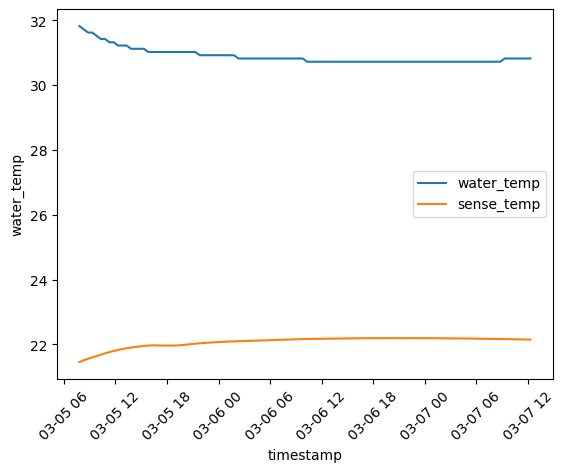

In [129]:
import seaborn as sns

sns.lineplot(data = df_results, x = df_scaled.index, y = "water_temp", label = "water_temp")
sns.lineplot(data = df_results, x = df_scaled.index, y = "sense_temp",label = "sense_temp")

plt.xticks(rotation = 45)
plt.legend()
plt.show()

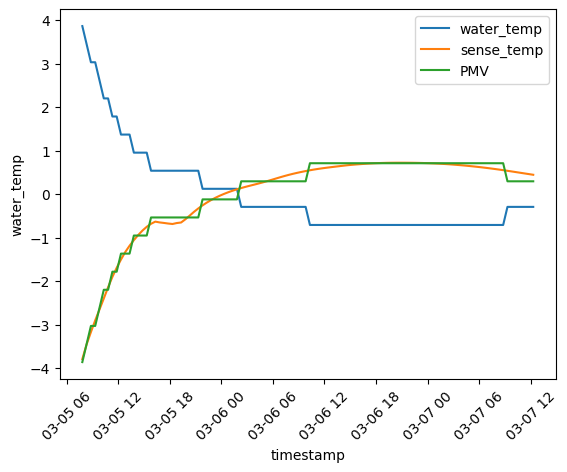

In [126]:
import seaborn as sns

sns.lineplot(data = df_scaled, x = df_scaled.index, y = "water_temp", label = "water_temp")
sns.lineplot(data = df_scaled, x = df_scaled.index, y = "sense_temp",label = "sense_temp")

plt.xticks(rotation = 45)
plt.legend()
plt.show()

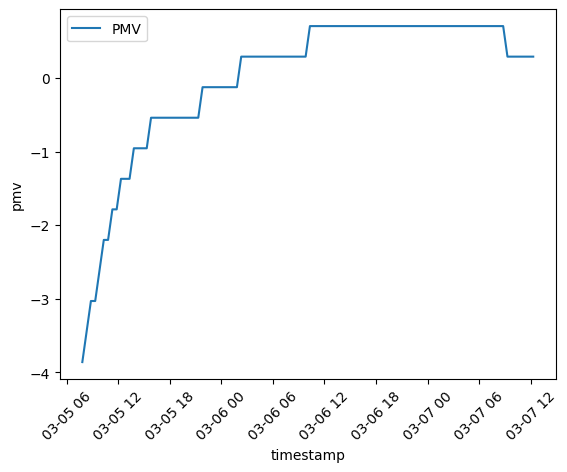

In [128]:
sns.lineplot(data = df_scaled, x = df_scaled.index, y = "pmv", label = "PMV")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

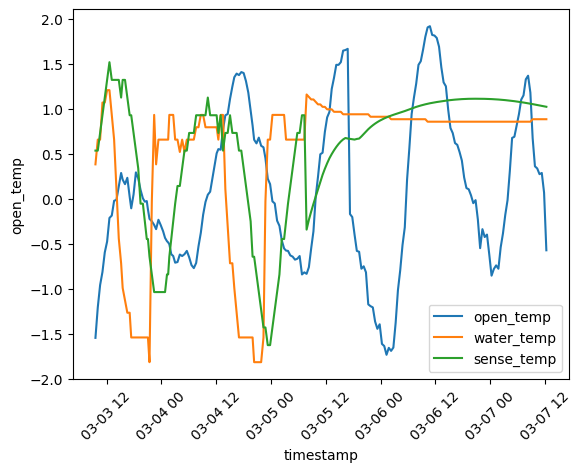

In [124]:
sns.lineplot(data = df_scaled2[-200:], x = df_scaled2.index[-200:], y = "open_temp", label = "open_temp")
sns.lineplot(data = df_scaled2[-200:], x = df_scaled2.index[-200:], y = "water_temp", label = "water_temp")
sns.lineplot(data = df_scaled2[-200:], x = df_scaled2.index[-200:], y = "sense_temp",label = "sense_temp")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### Sketching

In [ ]:
  #def replace_temperatures(self, df):
     #     print("Updating values...-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
     #     print("counter:", self.counter)
     #     print("upper_bound", self.upper_bound)
     #     print("lower_bound",self.lower_bound)
     #     global predictions, hvac_final
     #     print("predictions", predictions)
     #     print("hvac", hvac_final)
     #     # If statements to insert values saved in lists
     #     if len(predictions) > 0:
     #          df["sense_temp"][6:6 + len(predictions)] = predictions
     #          
     #     if len(hvac_final) > 0:
     #          df["water_temp"][5:5 + len(hvac_final)] = hvac_final
#
     #     # Create interaction term
     #     df["st_wt"] = df["sense_temp"] * df["water_temp"]
     #     print("updated:\n",df.head(30))
     #     return df